# Customer Churn Prediction

##### Problem statement
Decreasing the customer churn is a key goal for any business. Predicting customer churn (also known as Customer Attrition) represent an additional potenetial revenue source for any business. Customer churn impacts the cost to the business. Higher Customer churn leads to loss in revenue and the additional marketing costs involved with replacing those customers with new ones.

Our objective is to build a machine learning models to predict whether the customer will churn or not in the next six months.


##### Feature Description

|variable|Description|
|-|-|
|ID|Unique Identifier of a row|
|Age|Age of the customer|
|Gender|Gender of the customer(Male or Female)|
|Income|Yearly income of the customer|
|Balance|Average quarterly balance of the customer|
|Vintage|No. of years the customer is associated with bank|
|Transaction_status|Whether the customer has done any transaction in the past 3 months or not|
|Product_Holdings|No. of Product holdings with the bank|
|Credit_Card|Whether the customer has a credit card or not|
|Credit_Category|Catogory of a customer based on the credit score|
|Is_Churn|Whether the customer will churn in next 6 months or not|


In [1]:
# Loading lirbraries
import pandas as pd
import numpy as np 

# for visualization
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

# setting style for plots

plt.style.use('tableau-colorblind10')
plt.rc("font", size=16)
plt.rc("figure", figsize=(14, 8))
plt.rc("lines", linewidth=1.4)
plt.rc("xtick", labelsize=14,)
plt.rc("ytick", labelsize=14,)

sns.set_style("whitegrid")

import warnings
warnings.filterwarnings('ignore')

# for data-preprocessing
from scipy.stats import stats
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score

# for imbalance data
from imblearn.over_sampling import SVMSMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# for classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import ComplementNB

In [2]:
# function for plotting histogram.
def plot_hist(data, feature):
    
    # plot
    sns.histplot(data=data, x=feature, bins=10)
    
    plt.vlines(x= train_df[feature].mean(), 
           ymin=0, ymax=1400, 
           linewidth=4, color='red', label='Mean')
    
    plt.vlines(x= train_df[feature].median(), 
           ymin=0, ymax=1400, 
           linewidth=4, color='orange', label='Median')
    
    plt.title(f"Distribution of {feature}")
    plt.legend()
    
    
# function to remove outliers.
def remove_outliers(data, feature):
    
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_range = Q1 - 1.5 * IQR
    upper_range = Q3 + 1.5 * IQR
    
    data[feature] = np.where(data[feature] < lower_range, lower_range, data[feature])
    data[feature] = np.where(data[feature] > upper_range, upper_range, data[feature])
    
    

# function to plot the customer churn rate by transaction status by age_group.
def plot_transaction_churn_rate(age_group):
    
    age_grouped = train_df.groupby(by=['Age_group'])
    data = age_grouped.get_group(age_group)
    grouped_data = data.groupby(by=['Transaction_Status', 'Is_Churn']).count()['Age']
    
    # plot
    grouped_data.unstack().plot(kind='bar')

    plt.title(f"Customers churn by Transaction Status of {age_group} age group")
    plt.xlabel("Transaction Status")
    plt.ylabel("Count")

    plt.xticks([0, 1],['No', 'Yes'], rotation=0)
    plt.legend(['No', 'Yes'], title='Is_Churn')

    
# function to plot Customer churn rate by other columns.
def plot_churn_rate(feature):
    
    data = train_df.groupby(by=[feature, 'Is_Churn']).count()['Age']
    feature = feature.replace("_", " ")
    # calculating percentage churn rate by feature
    a = data / data.sum()*100
    
    # bar plot
    a.unstack().plot(kind='bar')
    
    plt.title(f"Customer Churn Rate by {feature}")
    plt.xlabel(f"{feature}")
    plt.ylabel("Percentage Churn rate")
    
    plt.xticks(rotation=0)
    plt.legend(['No', 'Yes'], title='Is_Churn')
    
    
# function for scaling data
def scaled(data):
    
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    scaled_data = pd.DataFrame(data=scaled_data, columns=data.columns)
    
    return scaled_data

In [3]:
## model evaluation 
def get_precision_recall(y_actual, y_preds):
    y_actual = np.array(list(np.array(y_actual.values).flat))  
    
    # precision of both class
    precision_0 = np.sum((y_actual==0) & (y_preds== 0)) / np.sum(y_preds==0)
    precision_1 = np.sum((y_actual==1) & (y_preds== 1)) / np.sum(y_preds==1)
    
    # recall for both class
    recall_0 = np.sum((y_actual==0) & (y_preds== 0)) / np.sum(y_actual==0)
    recall_1 = np.sum((y_actual==1) & (y_preds== 1)) / np.sum(y_actual==1)
    
    return precision_0, precision_1, recall_0, recall_1

def get_score(clf, clf_name, X, y):
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
    
    clf.fit(X_train, y_train)
    y_hat_train = clf.predict(X_train)
    y_hat = clf.predict(X_valid)
    
    precision_0, precision_1, recall_0, recall_1 = get_precision_recall(y_valid, y_hat)
    
    score_df.loc[clf_name, 'f1_socre_train'] = f1_score(y_train, y_hat_train)
    score_df.loc[clf_name, 'f1_socre_test'] = f1_score(y_valid, y_hat)
    score_df.loc[clf_name, 'precision_0'] = precision_0
    score_df.loc[clf_name, 'precision_1'] = precision_1
    score_df.loc[clf_name, 'recall_0'] = recall_0
    score_df.loc[clf_name, 'recall_1'] = recall_1
    
    return clf, score_df
    

In [4]:
# Reading data
train_df = pd.read_csv("train_PDjVQMB.csv", index_col='ID')
test_df = pd.read_csv("test_lTY72QC.csv", index_col='ID')
sample_solution_df = pd.read_csv("sample_OoSmYo5.csv", index_col='ID')

# f1_score dataframe for different classifiers
score_df = pd.DataFrame()

print("Train_df Shape:", train_df.shape)
print("Test_df Shape:", test_df.shape)

Train_df Shape: (6650, 10)
Test_df Shape: (2851, 9)


In [5]:
# view first 5 rows of data
train_df.head()

,Age,Gender,Income,Balance,Vintage,Transaction_Status,Product_Holdings,Credit_Card,Credit_Category,Is_Churn
ID,,,,,,,,,,
84e2fcc9,36,Female,5L - 10L,563266.44,4,0,1,0,Average,1
57fea15e,53,Female,Less than 5L,875572.11,2,1,1,1,Poor,0
8df34ef3,35,Female,More than 15L,701607.06,2,1,2,0,Poor,0
c5c0788b,43,Female,More than 15L,1393922.16,0,1,2,1,Poor,1
951d69c4,39,Female,More than 15L,893146.23,1,1,1,1,Good,1


In [6]:
test_df.head()

,Age,Gender,Income,Balance,Vintage,Transaction_Status,Product_Holdings,Credit_Card,Credit_Category
ID,,,,,,,,,
55480787,50,Female,More than 15L,1008636.39,2,1,2,1,Average
9aededf2,36,Male,5L - 10L,341460.72,2,0,2,1,Average
a5034a09,25,Female,10L - 15L,439460.10,0,0,2,1,Good
b3256702,41,Male,Less than 5L,28581.93,0,1,2,1,Poor
dc28adb5,48,Male,More than 15L,1104540.03,2,1,3+,0,Good


In [7]:
# Check datatypes of attributes.
print("# Train dataset datatypes:")
print(train_df.dtypes)

print("--"*20)
print("# Test dataset datatypes:")
print(test_df.dtypes)

# Train dataset datatypes:
Age                     int64
Gender                 object
Income                 object
Balance               float64
Vintage                 int64
Transaction_Status      int64
Product_Holdings       object
Credit_Card             int64
Credit_Category        object
Is_Churn                int64
dtype: object
----------------------------------------
# Test dataset datatypes:
Age                     int64
Gender                 object
Income                 object
Balance               float64
Vintage                 int64
Transaction_Status      int64
Product_Holdings       object
Credit_Card             int64
Credit_Category        object
dtype: object


In [8]:
# Summary statistics
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6650 entries, 84e2fcc9 to 57b39511
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 6650 non-null   int64  
 1   Gender              6650 non-null   object 
 2   Income              6650 non-null   object 
 3   Balance             6650 non-null   float64
 4   Vintage             6650 non-null   int64  
 5   Transaction_Status  6650 non-null   int64  
 6   Product_Holdings    6650 non-null   object 
 7   Credit_Card         6650 non-null   int64  
 8   Credit_Category     6650 non-null   object 
 9   Is_Churn            6650 non-null   int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 571.5+ KB


In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2851 entries, 55480787 to 36b81f59
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 2851 non-null   int64  
 1   Gender              2851 non-null   object 
 2   Income              2851 non-null   object 
 3   Balance             2851 non-null   float64
 4   Vintage             2851 non-null   int64  
 5   Transaction_Status  2851 non-null   int64  
 6   Product_Holdings    2851 non-null   object 
 7   Credit_Card         2851 non-null   int64  
 8   Credit_Category     2851 non-null   object 
dtypes: float64(1), int64(4), object(4)
memory usage: 222.7+ KB


We can see that, there are no missing values in both training and testing dataframes.

In [10]:
# Descriptive statistics
train_df.describe()

,Age,Balance,Vintage,Transaction_Status,Credit_Card,Is_Churn
count,6650.000000,6.650000e+03,6650.000000,6650.000000,6650.000000,6650.000000
mean,41.130226,8.045954e+05,2.250226,0.515789,0.664361,0.231128
std,9.685747,5.157549e+05,1.458795,0.499788,0.472249,0.421586
min,21.000000,6.300000e+01,0.000000,0.000000,0.000000,0.000000
25%,34.000000,3.922642e+05,1.000000,0.000000,0.000000,0.000000
50%,40.000000,7.649386e+05,2.000000,1.000000,1.000000,0.000000
75%,47.000000,1.147124e+06,3.000000,1.000000,1.000000,0.000000
max,72.000000,2.436616e+06,5.000000,1.000000,1.000000,1.000000


In [11]:
test_df.describe()

,Age,Balance,Vintage,Transaction_Status,Credit_Card
count,2851.000000,2.851000e+03,2851.000000,2851.000000,2851.000000
mean,41.252192,8.098990e+05,2.220975,0.506840,0.668888
std,9.616756,5.252003e+05,1.489941,0.500041,0.470696
min,21.000000,1.503000e+03,0.000000,0.000000,0.000000
25%,34.000000,4.009684e+05,1.000000,0.000000,0.000000
50%,40.000000,7.659125e+05,2.000000,1.000000,1.000000
75%,47.000000,1.154238e+06,3.000000,1.000000,1.000000
max,72.000000,2.434834e+06,5.000000,1.000000,1.000000


It seems like there are some outliers present in `Age` and `Balance` columns.

## Descriptive Analysis(Univariate Analysis)

In [12]:
# Categorical analysis.
categorical_cols = train_df.select_dtypes(include=object).columns

# Let's find number of unique values for the categorical attributes
print("## Uniques values for the categorical attributes")
print("--"*20)

print("# Train Data")
for col in categorical_cols:
    print(col + ":", train_df[col].unique())
    
print("--"*20)
print("# Test Data")
for col in categorical_cols:
    print(col + ":", test_df[col].unique())

## Uniques values for the categorical attributes
----------------------------------------
# Train Data
Gender: ['Female' 'Male']
Income: ['5L - 10L' 'Less than 5L' 'More than 15L' '10L - 15L']
Product_Holdings: ['1' '2' '3+']
Credit_Category: ['Average' 'Poor' 'Good']
----------------------------------------
# Test Data
Gender: ['Female' 'Male']
Income: ['More than 15L' '5L - 10L' '10L - 15L' 'Less than 5L']
Product_Holdings: ['2' '3+' '1']
Credit_Category: ['Average' 'Good' 'Poor']


In [13]:
# Number of occurrences for each unique values of the categorical attribute.
print("## Unique value counts for the categorical attributes")
print("--"*20)

print("# Train data")
for col in categorical_cols:
    print("--"*10)
    print(train_df[col].value_counts())
    
print("--"*20)
print("# Test data")
for col in categorical_cols:
    print("--"*10)    
    print(test_df[col].value_counts())

## Unique value counts for the categorical attributes
----------------------------------------
# Train data
--------------------
Male      3612
Female    3038
Name: Gender, dtype: int64
--------------------
10L - 15L        1885
5L - 10L         1847
Less than 5L     1573
More than 15L    1345
Name: Income, dtype: int64
--------------------
1     3200
2     3182
3+     268
Name: Product_Holdings, dtype: int64
--------------------
Poor       3076
Average    2043
Good       1531
Name: Credit_Category, dtype: int64
----------------------------------------
# Test data
--------------------
Male      1545
Female    1306
Name: Gender, dtype: int64
--------------------
10L - 15L        844
5L - 10L         794
Less than 5L     648
More than 15L    565
Name: Income, dtype: int64
--------------------
2     1359
1     1342
3+     150
Name: Product_Holdings, dtype: int64
--------------------
Poor       1270
Average     866
Good        715
Name: Credit_Category, dtype: int64


In [14]:
# Let's find percentage of unique value counts for 'churn' column.
train_df['Is_Churn'].value_counts() / train_df.shape[0] * 100

0    76.887218
1    23.112782
Name: Is_Churn, dtype: float64

*~76%* of data in `Is_Churn` column is **0**, while *23%* of data is **1**, which says that our data is highly imbalanced data.

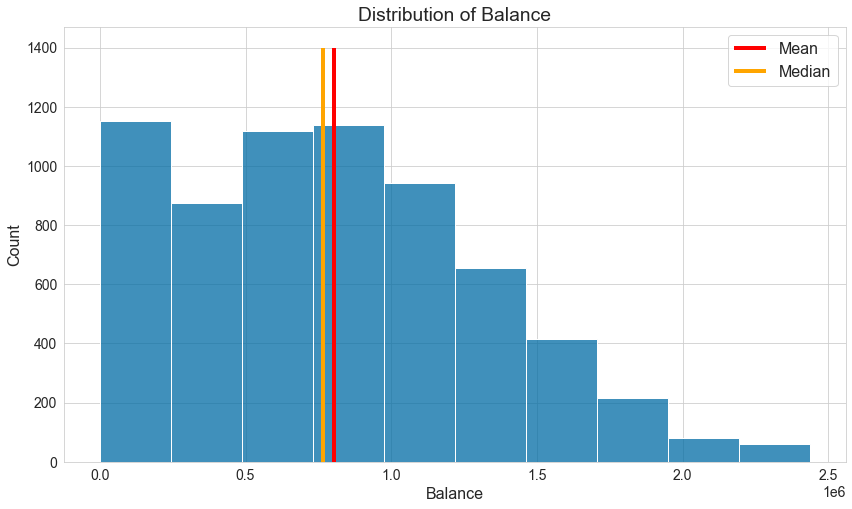

In [15]:
## Let's examine the 'Balance' of customers.
plot_hist(train_df, 'Balance')

Above plot shows that, data is right skewed, which says that there are some outliers present in data. Let's examine the outliers in both train data and test data using boxplot.

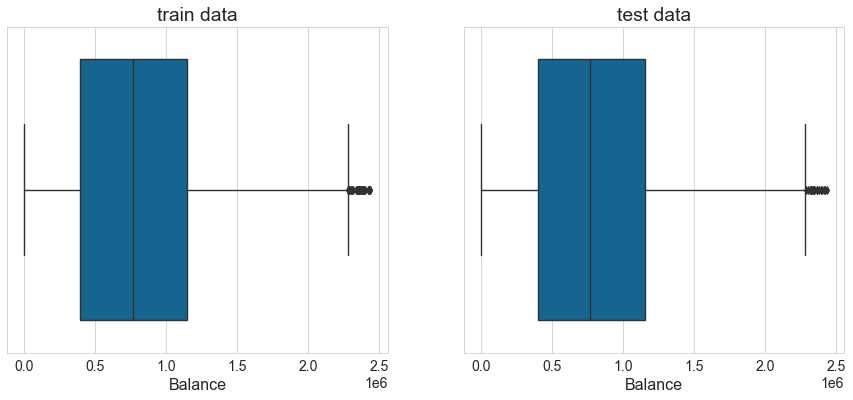

In [16]:
# boxplot
plt.figure(figsize=(15, 6))

plt.subplot(121)
sns.boxplot(data=train_df, x='Balance')
plt.title("train data")

plt.subplot(122)
sns.boxplot(data=test_df, x='Balance')
plt.title("test data")

plt.show()

We can see that, outliers present in `Balance` data.

In [17]:
# Let's remove outlier from 'Balance' column
remove_outliers(train_df, 'Balance') # train data
remove_outliers(test_df, 'Balance') # test data

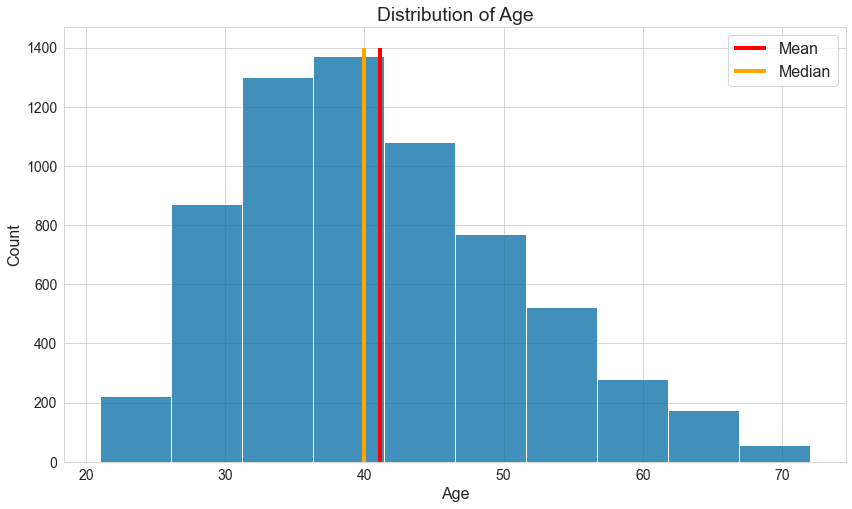

In [18]:
## Let's examine the 'Age' of customers.
plot_hist(train_df, 'Age')

Above plot show that, the data of `Age` is right skewed, which says that, there are some outliers present in data. 

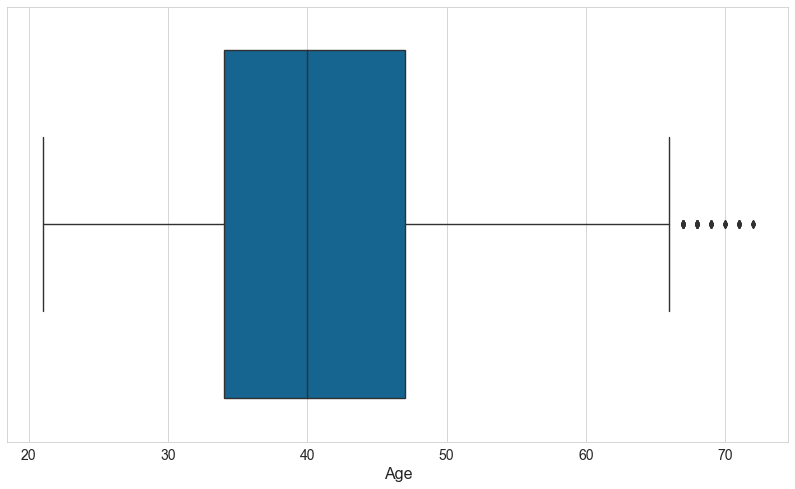

In [19]:
# box plot to see the outliers.
sns.boxplot(data=train_df, x='Age')
plt.show()

There some outliers present in `Age`.

In [20]:
# Creating new categorical column of age groups using `pd.cut` method.

bins = [20, 30, 40, 50, 60, 80]
labels = ['21-30', '31-40', '41-50', '51-60', '61-80']

train_df['Age_group'] = pd.cut(train_df.Age, bins=bins, labels=labels) # train data
test_df['Age_group'] = pd.cut(test_df.Age, bins=bins, labels=labels) # test data

train_df.head(2)

,Age,Gender,Income,Balance,Vintage,Transaction_Status,Product_Holdings,Credit_Card,Credit_Category,Is_Churn,Age_group
ID,,,,,,,,,,,
84e2fcc9,36,Female,5L - 10L,563266.44,4,0,1,0,Average,1,31-40
57fea15e,53,Female,Less than 5L,875572.11,2,1,1,1,Poor,0,51-60


## Correlation Analysis (bivariate analysis)

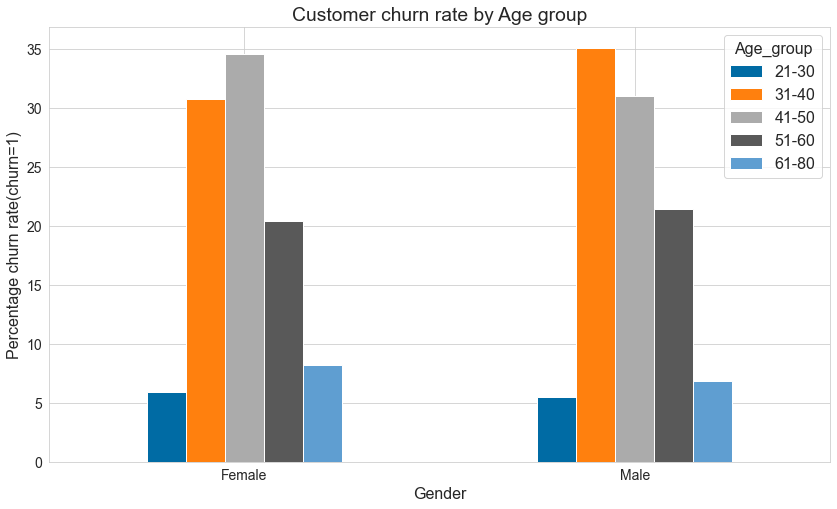

In [21]:
# Examine the customer churn rate by age_groups and gender.
data = pd.pivot_table(data=train_df, 
               values='Is_Churn', 
               index='Gender', columns='Age_group', aggfunc=sum)

data.loc['Female'] = round(data.loc['Female'] / data.loc['Female'].sum() * 100, 2)
data.loc['Male'] = round(data.loc['Male'] / data.loc['Male'].sum() * 100, 2)

# plot
data.plot(kind='bar')

plt.title("Customer churn rate by Age group")
plt.xlabel("Gender")
plt.ylabel("Percentage churn rate(churn=1)")

plt.xticks(rotation=0)
plt.show()

High Churn rate is observed for the age group between 30 to 50 in both *Female* and *Male*.

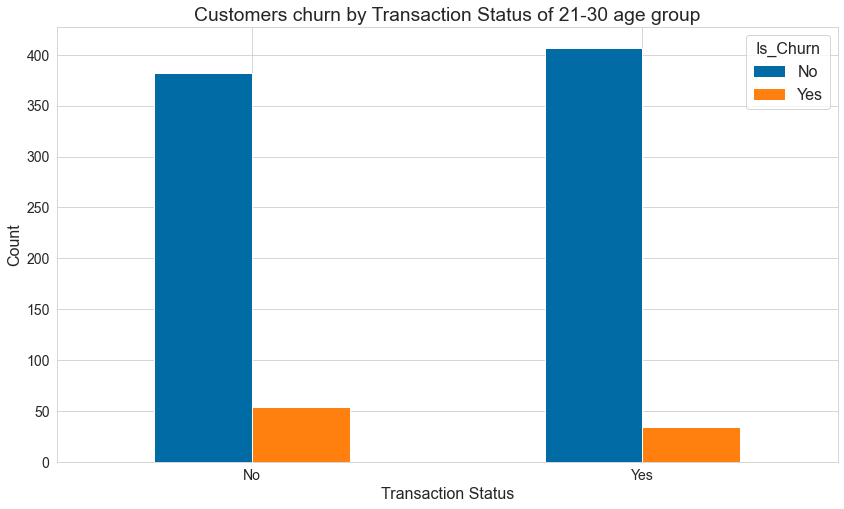

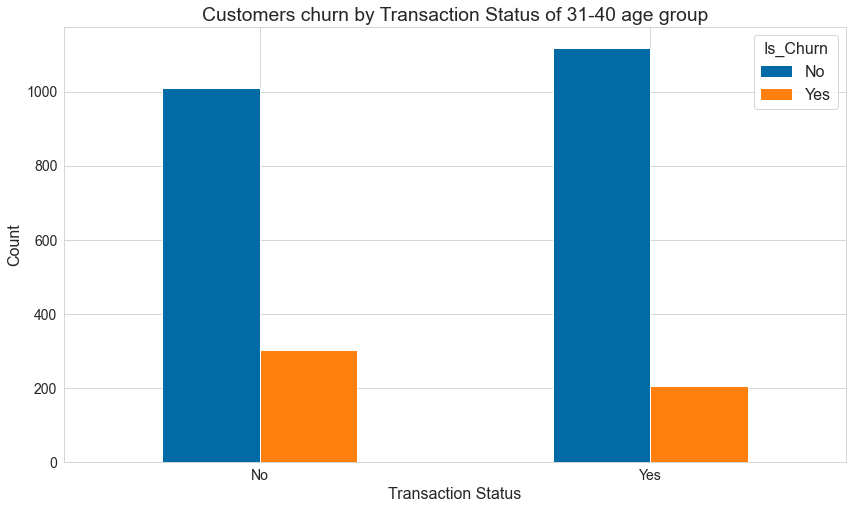

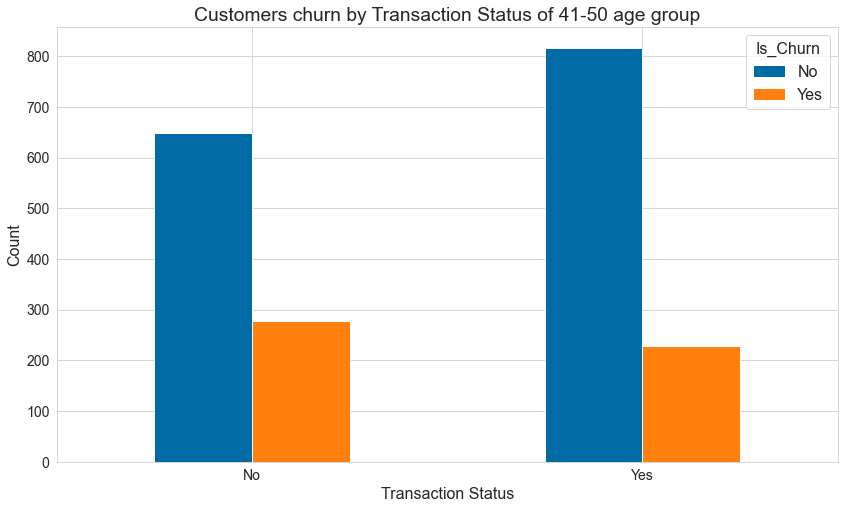

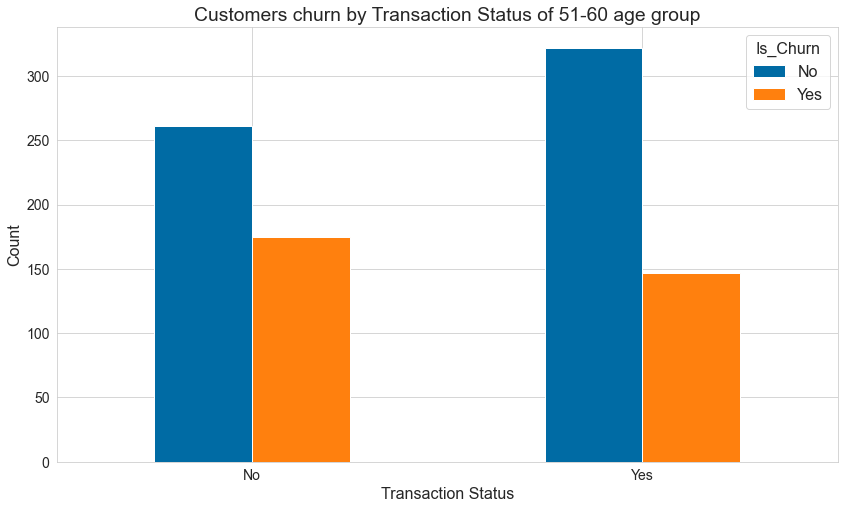

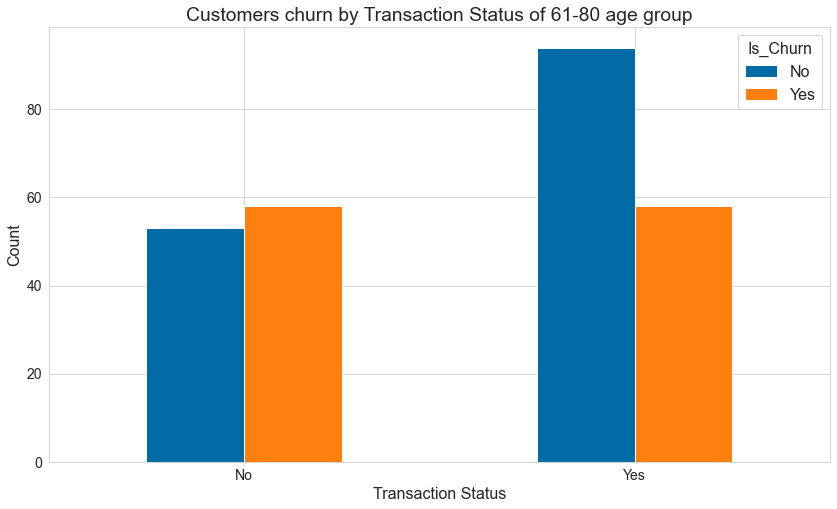

In [22]:
# for age groups
for label in labels:
    plot_transaction_churn_rate(label)

Above plot shows, the churn count for different age groups, we can see that the customer retention is more common for the customers with transaction in the past 3 months than customers without transaction in past 3 months for all age groups except for customers in age group `61-80`.

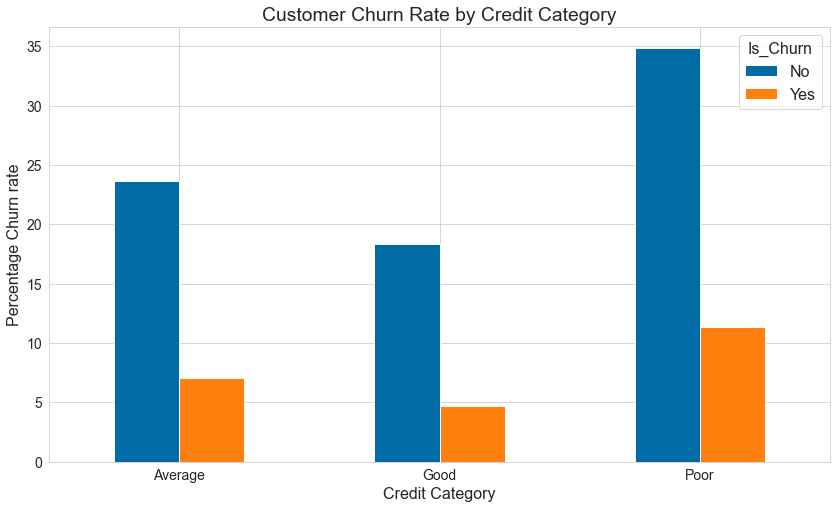

In [23]:
## Examine the customer churn rate by credit category
# plot
plot_churn_rate('Credit_Category')

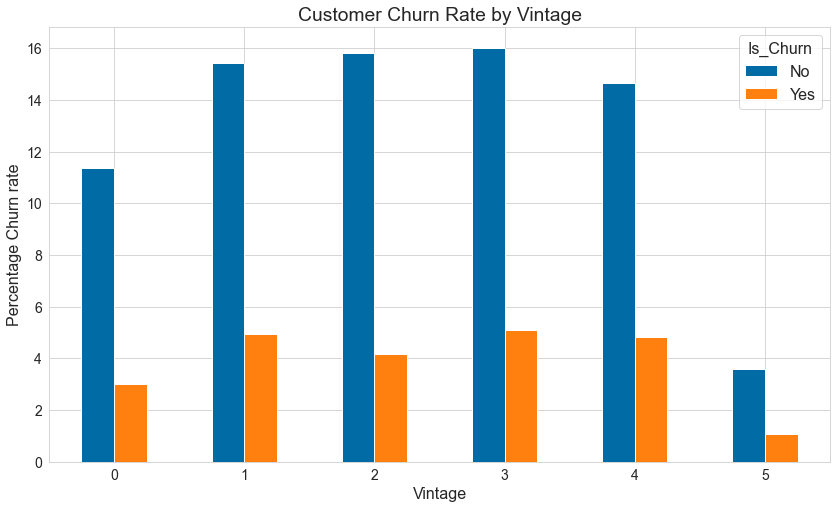

In [24]:
# Vintage - No. of years the customer is associated with bank.
# plot
plot_churn_rate('Vintage')

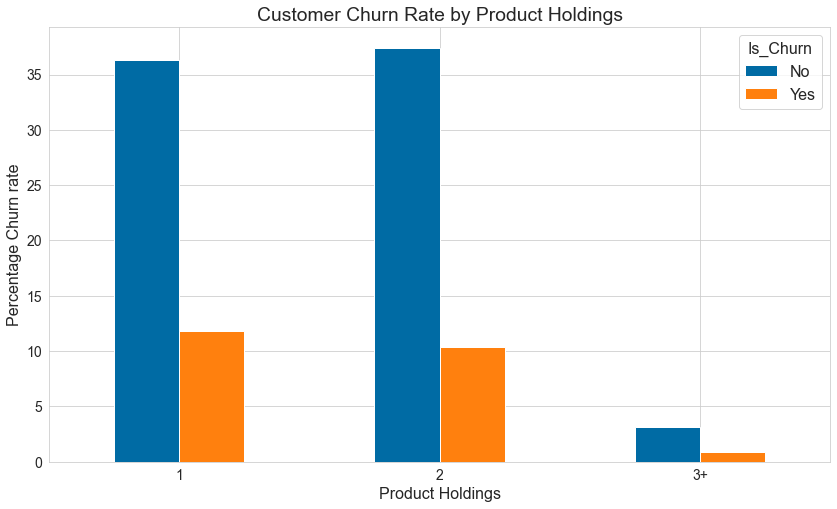

In [25]:
# Product_Holdings - No. of Product holdings with the bank
plot_churn_rate('Product_Holdings')

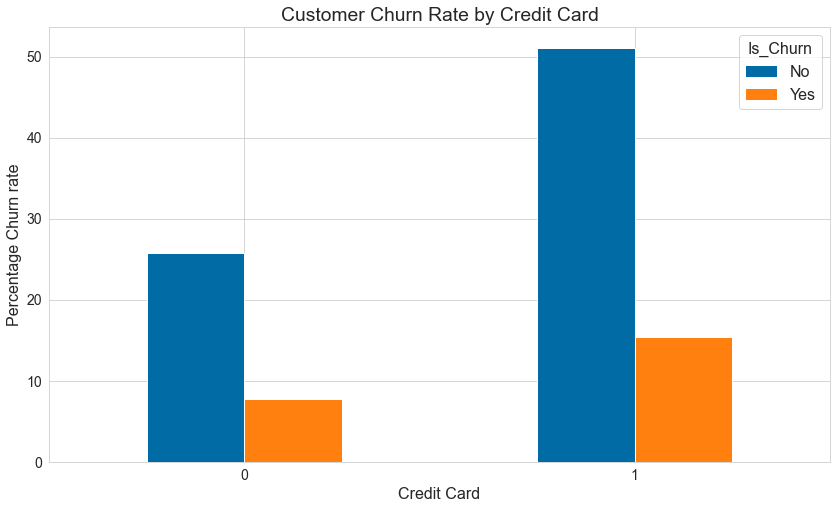

In [26]:
# Credit_Card- Does customer has credit card or not?
plot_churn_rate('Credit_Card')

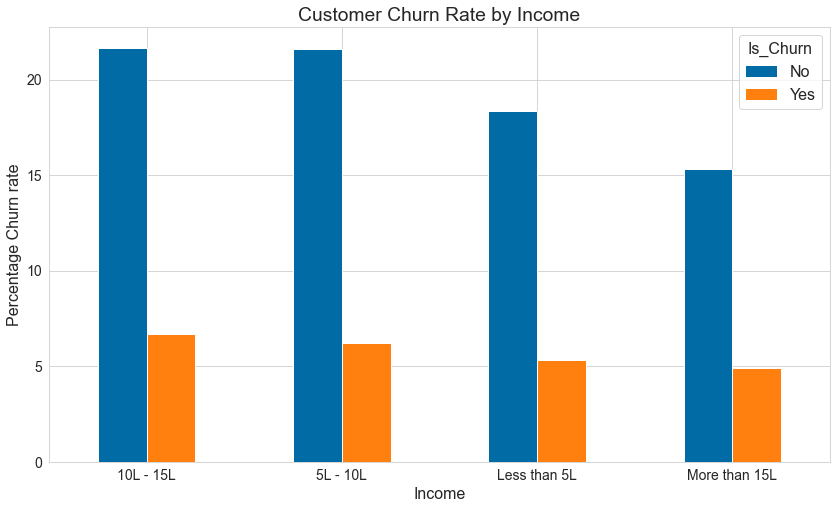

In [27]:
## Income
plot_churn_rate('Income')

In [28]:
# hypothesis test using `chi-square test` to test the independence of two variables.
## H0: 'Vintage' and 'Is_churn' are independent.
## H1: "Vintage" and "Is_churn" are not independent.

# Contingency table
data = pd.crosstab(train_df['Vintage'], train_df['Is_Churn'])
chi_stats, p_value, dof, expected = chi2_contingency(observed=data, correction = False)

print("P-value: ", p_value)
alpha = 0.05
if p_value <= alpha:
    print("Null hypothesis H0 is rejected, hence Variables are dependent")
    
else:
    print("Null hypothesis H0 is accepted, Variables are independent")    

P-value:  0.07091364326527481
Null hypothesis H0 is accepted, Variables are independent


In [29]:
features = ['Gender', 'Balance', 'Transaction_Status', 'Income', 'Product_Holdings', 'Credit_Category', 'Age_group']

X = train_df[features]
y = train_df['Is_Churn']
test = test_df[features]

In [30]:
# Convert the categorical features into numerical using encoding technique
numeric_cols = ['Transaction_Status', 'Balance']
categorical_cols = X.select_dtypes(exclude=[int, float]).columns

# using 'get_dummies()' method of pandas
# Train data
train_data = pd.get_dummies(X[categorical_cols])

# Test data
test_data = pd.get_dummies(test[categorical_cols])

In [31]:
# Create X and y dataframe.
X = pd.concat([X[numeric_cols], train_data], axis=1)
y = train_df['Is_Churn']

# Create a new test data
test = pd.concat([test[numeric_cols], test_data], axis=1) 

In [32]:
# log transformation
X['Balance'] = np.log(X['Balance'])
test['Balance'] = np.log(test['Balance'])

# scaled the data
X = scaled(X)
test = scaled(test)

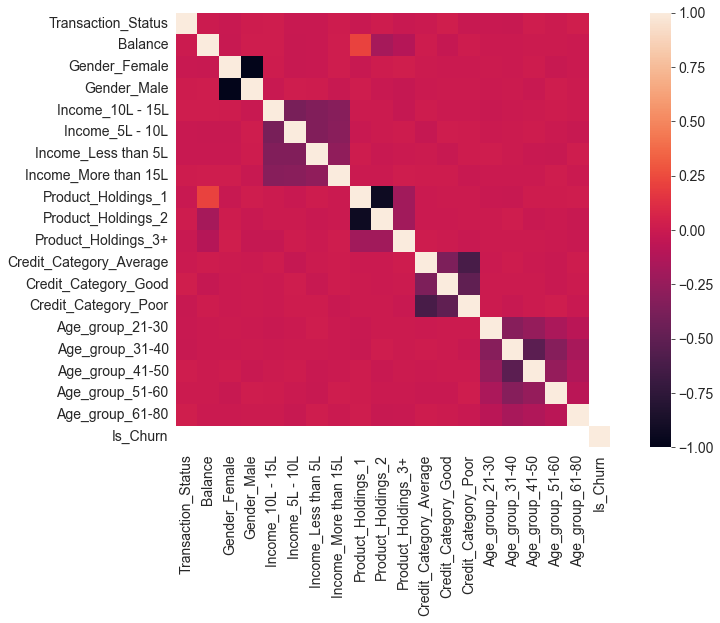

In [33]:
# correlation 
data = pd.concat([X, y], axis=1)
corr = data.corr()

# plot
sns.heatmap(corr, square=True)
plt.show()

## Model Evaluation

In [34]:
# model building
# DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=42)
clf, score_df = get_score(clf, 'DecisionTreeClassifier', X, y)
score_df

,f1_socre_train,f1_socre_test,precision_0,precision_1,recall_0,recall_1
DecisionTreeClassifier,1.0,0.265403,0.770977,0.264984,0.770217,0.265823


In [35]:
# Naive Bayes classifier
nb_clf = ComplementNB()
nb_clf, score_df = get_score(nb_clf, 'NaiveBayesComplementNB', X, y)

# Gradient Boosting Classifier
gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf, score_df = get_score(gb_clf, 'GradientBoostingClassifier', X, y)

In [36]:
score_df

,f1_socre_train,f1_socre_test,precision_0,precision_1,recall_0,recall_1
DecisionTreeClassifier,1.000000,0.265403,0.770977,0.264984,0.770217,0.265823
NaiveBayesComplementNB,0.412538,0.406147,0.821769,0.310924,0.595661,0.585443
GradientBoostingClassifier,0.123100,0.069565,0.766334,0.413793,0.983235,0.037975


Data is highly imbalance so let's balance the data using `Imbalance Learn` Python library.

### Using RandomOverSampler

In [37]:
oversample = RandomOverSampler(sampling_strategy='minority', random_state=42)
x_res, y_res = oversample.fit_resample(X, y)
y_res.value_counts()

1    5113
0    5113
Name: Is_Churn, dtype: int64

In [38]:
# Naive Bayes classifier
nb_clf = ComplementNB()
nb_clf, score_df = get_score(nb_clf, 'NaiveBayes_ComplementNB_over_resample', x_res, y_res)

# Gradient Boosting Classifier
gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf, score_df = get_score(gb_clf,  'GradientBoostingClassifier_over_resample', x_res, y_res)

### Using SVMSOMTE

In [39]:
oversample = SVMSMOTE(sampling_strategy='minority', random_state=42)
x_res, y_res = oversample.fit_resample(X, y)
x_res[x_res < 0] = 0

y_res.value_counts()

1    5113
0    5113
Name: Is_Churn, dtype: int64

In [40]:
# Naive Bayes classifier
nb_clf = ComplementNB()
nb_clf, score_df = get_score(nb_clf, 'NaiveBayes_ComplementNB_over_svmsomte_resample', x_res, y_res)

# Gradient Boosting Classifier
gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf, score_df = get_score(gb_clf,  'GradientBoostingClassifier_over_svmsomte_resample', x_res, y_res)

In [41]:
# prediction
predictions = gb_clf.predict(test)
sample_solution_df['Is_Churn'] = predictions
    
# To save dataframe to csv file
sample_solution_df.to_csv("Solution_Submission.csv")

### Using RandomUnderSampler

In [42]:
undersample = RandomUnderSampler(sampling_strategy='majority', random_state=42)
x_res, y_res = undersample.fit_resample(X, y)
y_res.value_counts()

0    1537
1    1537
Name: Is_Churn, dtype: int64

In [43]:
# Naive Bayes classifier
nb_clf = ComplementNB()
nb_clf, score_df = get_score(nb_clf, 'NaiveBayes_ComplementNB_under_resample', x_res, y_res)

# Gradient Boosting Classifier
gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf, score_df = get_score(gb_clf,  'GradientBoostingClassifier_under_resample', x_res, y_res)

### Combining Random Oversampling and Undersampling

In [44]:
oversample = RandomOverSampler(random_state=42)
undersample = RandomUnderSampler(random_state=42)

X, y = oversample.fit_resample(X, y)
X, y = undersample.fit_resample(X, y)

# Naive Bayes classifier
nb_clf = ComplementNB()
nb_clf, score_df = get_score(nb_clf, 'NaiveBayes_ComplementNB_combine_resample', x_res, y_res)

# Gradient Boosting Classifier
gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf, score_df = get_score(gb_clf,  'GradientBoostingClassifier_combine_resample', x_res, y_res)

In [45]:
score_df

,f1_socre_train,f1_socre_test,precision_0,precision_1,recall_0,recall_1
DecisionTreeClassifier,1.000000,0.265403,0.770977,0.264984,0.770217,0.265823
NaiveBayesComplementNB,0.412538,0.406147,0.821769,0.310924,0.595661,0.585443
GradientBoostingClassifier,0.123100,0.069565,0.766334,0.413793,0.983235,0.037975
NaiveBayes_ComplementNB_over_resample,0.602904,0.622696,0.624750,0.614943,0.608949,0.630648
GradientBoostingClassifier_over_resample,0.659004,0.659320,0.662231,0.643592,0.629377,0.675835
NaiveBayes_ComplementNB_over_svmsomte_resample,0.656189,0.657157,0.660524,0.658128,0.662451,0.656189
GradientBoostingClassifier_over_svmsomte_resample,0.691299,0.691484,0.691750,0.718982,0.742218,0.666012
NaiveBayes_ComplementNB_under_resample,0.598852,0.592593,0.625397,0.586667,0.613707,0.598639
GradientBoostingClassifier_under_resample,0.698786,0.604800,0.630282,0.570997,0.557632,0.642857
NaiveBayes_ComplementNB_combine_resample,0.598852,0.592593,0.625397,0.586667,0.613707,0.598639


The `SVMSOMTE` over sampling method of `imblearn` library gives better score as compare to other methods. `GradientBoostingClassifier` with `SVMSMOTE` gives highest `f1_score`.